In [1]:
import numpy as np
import os
import pickle
import re
import scipy
import torch
import wfdb

from torch.utils.data import Dataset

In [2]:
def extract_segment_with_padding(z, k, N):
    start_idx = k - N
    end_idx = k + N + 1
    if start_idx < 0:
        padding_left = np.median(z[:end_idx])
        segment = np.concatenate([np.full(-start_idx, padding_left), z[:end_idx]])
    elif end_idx > len(z):
        padding_right = np.median(z[start_idx:])
        segment = np.concatenate([z[start_idx:], np.full(end_idx - len(z), padding_right)])
    else:
        segment = z[start_idx:end_idx]
    return segment

In [20]:
class MIT_BIH_Arythmia_Base(Dataset):
    def __init__(self, N, M, dataset_dir='Datasets/files/', fs=10, output_dir="processed_data/", histogram_path=None):
        self.N = N
        self.M = M
        self.dataset_dir = dataset_dir
        self.fs = fs
        self.output_dir = output_dir
        self.cumulative_histogram = []
        self.histogram_path = histogram_path
    
    class MIT_BIH_AtrialFibrillation():
        def __init__(self):
            self.afib_data = []
    
    class MIT_BIH_Normal():
        def __init__(self):
            self.normal_data = []

    def process_records(self):
        """Przetwarzanie pojedynczego rekordu."""
        if self.histogram_path and os.path.exists(self.histogram_path):
            with open(self.histogram_path, 'rb') as f:
                self.cumulative_histogram = pickle.load(f)
            print("Załadowano histogram:", self.histogram_path)
        else:
            os.makedirs(self.output_dir, exist_ok=True)
            os.makedirs(self.output_dir + 'af/', exist_ok=True)
            os.makedirs(self.output_dir + 'normal/', exist_ok=True)
            exclusion_lst = ["00735", "03665", "04043", "04936", "05091", "06453", "08378", "08405", "08434", "08455"]
            start_idx = 0
            for file in os.listdir(self.dataset_dir):
                name = re.match(r'^(.*\d\d+)\.atr$', file)
                if name and name.group(1) not in exclusion_lst:
                    print(f"Przetwarzanie: {name.group(1)}")
                    record = wfdb.rdsamp(f"{self.dataset_dir}{name.group(1)}")
                    annotation = wfdb.rdann(f"{self.dataset_dir}{name.group(1)}", 'atr')
                    signal = record[0][:, 0]
                    fs_original = record[1]["fs"]
                    num_samples_target = int(signal.shape[0] * self.fs / fs_original)
                    resampled_signal = scipy.signal.resample(signal, num_samples_target)
                    annotation_times_resampled = (annotation.sample * self.fs) / fs_original
                    data = {
                        "rec": resampled_signal,
                        "ann": {
                            "sample": annotation_times_resampled.astype(int).tolist(),
                            "aux_note": annotation.aux_note
                        }
                    }
                    # print(annotation.aux_note)
                    if "(AFIB" in annotation.aux_note:
                        output_filename = os.path.join(self.output_dir + 'af/', f"{name.group(1)}.pkl")
                    else:
                        output_filename = os.path.join(self.output_dir + 'normal/', f"{name.group(1)}.pkl")
                    with open(output_filename, 'wb') as f:
                        pickle.dump(data, f)
                    num_samples = len(data["ann"]["sample"])
                    self.cumulative_histogram.append((start_idx, start_idx + num_samples, output_filename))
                    start_idx += num_samples
            histogram_path = os.path.join(self.output_dir, "cumulative_histogram.pkl")
            with open(histogram_path, 'wb') as f:
                pickle.dump(self.cumulative_histogram, f)
            print("Przetwarzanie zakończone. Dane zapisane w:", self.output_dir)     

    def __len__(self):
        return self.cumulative_histogram[-1][1]

    def __getitem__(self, idx):
    # Przejdź przez histogram skumulowany, aby znaleźć odpowiedni plik i zakres indeksów
        for start, end, filename in self.cumulative_histogram:
            if start <= idx < end:
                local_idx = idx - start  # Oblicz indeks lokalny w danym pliku
                break
        else:
            raise IndexError("Index out of range")  # Jeśli nie znajdziesz odpowiedniego zakresu, zgłoś błąd
        
        # Załaduj dane z odpowiedniego pliku
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        # Pobierz sygnał EKG i informacje o annotacjach
        rec = data["rec"]
        sample_idx = data["ann"]["sample"][local_idx]  # Indeks próbki w danym pliku
        aux_note = data["ann"]["aux_note"][local_idx]  # Etykieta (np. AFIB lub NORMAL)
        
        # Wyciąć odpowiedni segment EKG wokół punktu annotacji
        segment = extract_segment_with_padding(rec, sample_idx, self.N)
        
        # Ustal etykietę: 1 dla AFIB, 0 dla NORMAL
        label = 1 if aux_note == '(AFIB' else 0
        return torch.Tensor(segment).unsqueeze(0), label

    def count_afibs(self):
        afib_count = 0
        for start, end, filename in self.cumulative_histogram:
            # Załaduj dane z pliku
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            
            # Sprawdź wszystkie etykiety i policz AFIB
            for aux_note in data["ann"]["aux_note"]:
                if "(AFIB" in aux_note:
                    afib_count += 1
        return afib_count 


In [21]:
ds = MIT_BIH_Arythmia_Base(100,5,fs=100,dataset_dir='physionet.org/files/ltafdb/1.0.0/')
ds.process_records()

Przetwarzanie: 118
Przetwarzanie: 25


KeyboardInterrupt: 

In [ ]:
class MIT_BIH_Arythmia_Base(Dataset):
    def __init__(self, N, M, dataset_dir='Datasets/files/', fs=10, output_dir="processed_data3/", histogram_path=None):
        self.N = N
        self.M = M
        self.dataset_dir = dataset_dir
        self.fs = fs
        self.output_dir = output_dir
        self.cumulative_histogram = []
        self.histogram_path = histogram_path
    
    class MIT_BIH_AtrialFibrillation:
        def __init__(self):
            self.afib_data = []
    
    class MIT_BIH_Normal:
        def __init__(self):
            self.normal_data = []

    def process_records(self):
        """Przetwarzanie rekordów."""
        if self.histogram_path and os.path.exists(self.histogram_path):
            with open(self.histogram_path, 'rb') as f:
                self.cumulative_histogram = pickle.load(f)
            print("Załadowano histogram:", self.histogram_path)
        else:
            os.makedirs(self.output_dir, exist_ok=True)
            afib_dir = os.path.join(self.output_dir, 'af/')
            normal_dir = os.path.join(self.output_dir, 'normal/')
            os.makedirs(afib_dir, exist_ok=True)
            os.makedirs(normal_dir, exist_ok=True)
            exclusion_lst = ["00735", "03665", "04043", "04936", "05091", "06453", "08378", "08405", "08434", "08455"]
            start_idx = 0

            for file in os.listdir(self.dataset_dir):
                name = re.match(r'^(.*\d\d+)\.atr$', file)
                if name and name.group(1) not in exclusion_lst:
                    print(f"Przetwarzanie: {name.group(1)}")
                    record = wfdb.rdsamp(f"{self.dataset_dir}{name.group(1)}")
                    annotation = wfdb.rdann(f"{self.dataset_dir}{name.group(1)}", 'atr')
                    signal = record[0][:, 0]
                    fs_original = record[1]["fs"]
                    num_samples_target = int(signal.shape[0] * self.fs / fs_original)
                    resampled_signal = scipy.signal.resample(signal, num_samples_target)
                    annotation_times_resampled = (annotation.sample * self.fs) / fs_original
                    afib_segments = []
                    normal_segments = []

                    for i, aux_note in enumerate(annotation.aux_note):
                        sample_idx = int(annotation_times_resampled[i])
                        segment = extract_segment_with_padding(resampled_signal, sample_idx, self.N)

                        if "(AFIB" in aux_note:
                            afib_segments.append(segment.tolist())
                            # Dodaj segmenty otoczenia
                            if sample_idx - 2 * self.N > 0:
                                pre_segment = extract_segment_with_padding(resampled_signal, sample_idx - self.N, self.N)
                                afib_segments.append(pre_segment.tolist())
                            if sample_idx + 2 * self.N < len(resampled_signal):
                                post_segment = extract_segment_with_padding(resampled_signal, sample_idx + self.N, self.N)
                                afib_segments.append(post_segment.tolist())
                        else:
                            normal_segments.append(segment.tolist())

                    # Zafib
                    if afib_segments:
                        afib_file = os.path.join(afib_dir, f"{name.group(1)}_afib.pkl")
                        with open(afib_file, 'wb') as f:
                            pickle.dump(afib_segments, f)

                    # normal
                    if normal_segments:
                        normal_file = os.path.join(normal_dir, f"{name.group(1)}_normal.pkl")
                        with open(normal_file, 'wb') as f:
                            pickle.dump(normal_segments, f)

                    num_samples = len(annotation.sample)
                    self.cumulative_histogram.append((start_idx, start_idx + num_samples, name.group(1)))
                    start_idx += num_samples

            histogram_path = os.path.join(self.output_dir, "cumulative_histogram.pkl")
            with open(histogram_path, 'wb') as f:
                pickle.dump(self.cumulative_histogram, f)
            print("Przetwarzanie zakończone. Dane zapisane w:", self.output_dir)

    def __len__(self):
        return self.cumulative_histogram[-1][1]

    def __getitem__(self, idx):
        raise NotImplementedError("Dane są zapisane w osobnych plikach. __getitem__ nie jest wymagane.")

    def count_afibs(self):
        """Liczba segmentów AFIB."""
        afib_count = 0
        for start, end, filename in self.cumulative_histogram:
            with open(filename, 'rb') as f:
                data = pickle.load(f)
            for aux_note in data["ann"]["aux_note"]:
                if "(AFIB" in aux_note:
                    afib_count += 1
        return afib_count


In [12]:
ds = MIT_BIH_Arythmia_Base(100,5,fs=100,dataset_dir='physionet.org/files/ltafdb/1.0.0/')
ds.process_records()

Przetwarzanie: 101
Przetwarzanie: 25
Przetwarzanie: 19
Przetwarzanie: 116
Przetwarzanie: 42
Przetwarzanie: 110
Przetwarzanie: 58
Przetwarzanie: 112
Przetwarzanie: 205
Przetwarzanie: 122
Przetwarzanie: 20
Przetwarzanie: 24
Przetwarzanie: 06
Przetwarzanie: 45
Przetwarzanie: 17
Przetwarzanie: 05
Przetwarzanie: 48
Przetwarzanie: 111
Przetwarzanie: 35
Przetwarzanie: 200
Przetwarzanie: 64
Przetwarzanie: 204
Przetwarzanie: 00
Przetwarzanie: 53
Przetwarzanie: 72
Przetwarzanie: 69
Przetwarzanie: 201
Przetwarzanie: 113
Przetwarzanie: 65
Przetwarzanie: 21
Przetwarzanie: 121
Przetwarzanie: 30


/home/zosia/dnn/dnn_ecg/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zosia/dnn/dnn_ecg/env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Przetwarzanie: 75
Przetwarzanie: 60
Przetwarzanie: 22
Przetwarzanie: 34
Przetwarzanie: 100
Przetwarzanie: 33
Przetwarzanie: 74
Przetwarzanie: 114
Przetwarzanie: 13
Przetwarzanie: 102
Przetwarzanie: 55
Przetwarzanie: 115
Przetwarzanie: 43
Przetwarzanie: 03
Przetwarzanie: 117
Przetwarzanie: 38
Przetwarzanie: 118
Przetwarzanie: 37
Przetwarzanie: 23
Przetwarzanie: 49
Przetwarzanie: 203
Przetwarzanie: 62
Przetwarzanie: 207
Przetwarzanie: 47
Przetwarzanie: 18
Przetwarzanie: 51
Przetwarzanie: 202
Przetwarzanie: 26
Przetwarzanie: 16
Przetwarzanie: 103
Przetwarzanie: 68
Przetwarzanie: 208
Przetwarzanie: 70
Przetwarzanie: 12
Przetwarzanie: 56
Przetwarzanie: 206
Przetwarzanie: 44
Przetwarzanie: 71
Przetwarzanie: 120
Przetwarzanie: 15
Przetwarzanie: 10
Przetwarzanie: 39
Przetwarzanie: 07
Przetwarzanie: 28
Przetwarzanie: 105
Przetwarzanie: 119
Przetwarzanie: 54
Przetwarzanie: 08
Przetwarzanie: 01
Przetwarzanie: 104
Przetwarzanie: 32
Przetwarzanie: 11
Przetwarzanie zakończone. Dane zapisane w: proce

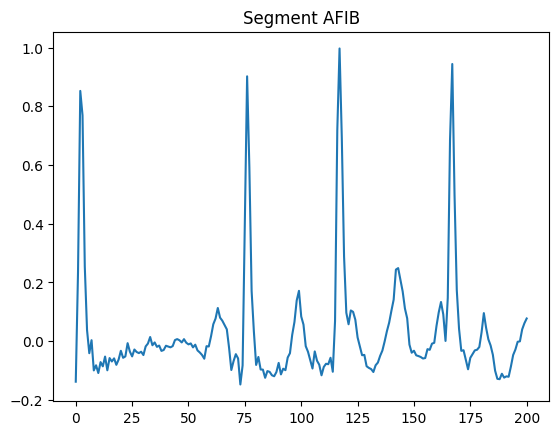

In [ ]:
import pickle
import matplotlib.pyplot as plt

with open('processed_data3/af/05_afib.pkl', 'rb') as f:
    afib_segments = pickle.load(f)

plt.plot(afib_segments[0])
plt.title("Segment AFIB")
plt.show()

if len(afib_segments) > 1:
    plt.plot(afib_segments[1])
    plt.title("Otoczenie przed/po AFIB")
    plt.show()
